In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

# Load the file
file_path = 'SP_train.npy'
train_data = np.load('/kaggle/input/nlproberta/SP-train.npy', allow_pickle=True)

# Initialize lists to store texts and labels
train_texts = []
train_labels = []

# Iterate through the data and prepare texts and labels
for data in train_data:
    Q = data['question']
    X = '<s>' + Q + '</s>'

    for i in range(4):
        Y = X + data['choice_list'][i] + '</s>'
        train_texts.append(Y)

        # Labeling
        if data['choice_order'][i] == 0:
            train_labels.append(1)
        else:
            train_labels.append(0)

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)  # Binary classification

# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,  # RoBERTa does not require [CLS] or [SEP] tokens
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create train dataset
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=512)

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=3,
    per_device_train_batch_size=1,
    # per_device_eval_batch_size=8,
    # warmup_steps=500,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()


2024-04-25 00:29:16.240170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 00:29:16.240307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 00:29:16.449528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

  ·····
  ····


In [5]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import numpy as np
import matplotlib.pyplot as plt
from transformers import DebertaForSequenceClassification, DebertaTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

train_file_path = "/kaggle/input/nlproberta/SP-train.npy"
eval_file_path = "/kaggle/input/sp-eval/SP_eval_data_for_practice.npy"

train_data = np.load(train_file_path, allow_pickle=True)
eval_data = np.load(eval_file_path, allow_pickle=True)

train_texts = []
train_labels = []
eval_texts = []

with open('/kaggle/input/list-pkl/list.pkl', 'rb') as f:
    eval_labels = pickle.load(f)

for data in train_data:
    Q = data['question']
    X = '[CLS] ' + Q + ' [SEP] '
    for i in range(4):
        Y = X + data['choice_list'][i] + ' [SEP]'
        train_texts.append(Y)
        if data['choice_order'][i] == 0:
            train_labels.append(1)
        else:
            train_labels.append(0)

for data in eval_data:
    Q = data['question']
    X = '[CLS] ' + Q + ' [SEP] '
    for i in range(4):
        Y = X + data['choice_list'][i] + ' [SEP]'
        eval_texts.append(Y)

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }



# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)  # Binary classification

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=512)
eval_dataset = CustomDataset(eval_texts, eval_labels, tokenizer, max_len=512)

training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    num_train_epochs=5,
    per_device_train_batch_size=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    evaluation_strategy="epoch",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()

# Evaluation
def evaluate(texts, labels, model, tokenizer):
    preds = []
    orgs = []

    for i in range(0, len(texts), 4):
        ques_batch = texts[i:i + 4]
        labels_batch = labels[i:i + 4]

        orgs.extend([label.index(1) for label in labels_batch])

        temp = []

        for q in ques_batch:
            inputs = tokenizer(q, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = model(**inputs)
                prob_dist = torch.softmax(outputs.logits, dim=1)
                prob = prob_dist[:, 1].item()
                temp.append(prob)

        array = np.array(temp)
        index_of_largest = np.argmax(array)
        preds.append(index_of_largest)

    accuracy = accuracy_score(preds, orgs)
    print("Accuracy: ", accuracy)

evaluate(train_texts, train_labels, model, tokenizer)
evaluate(eval_texts, eval_labels, model, tokenizer)

# # Plot
# # Assuming you have training and validation losses recorded
# training_losses = [0.783700, 0.556500, 0.332600, 0.206600, 0.085900]
# validation_losses = [1.136715, 0.688549, 0.670105, 0.718898, 0.778404]
# epochs = [1, 2, 3, 4, 5]

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, training_losses, marker='o', label='Training Loss')
# plt.plot(epochs, validation_losses, marker='x', label='Validation Loss')

# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Losses')
# plt.legend()
# plt.show()

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser 

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.057600,0.970605
2,1.051000,1.043503
3,1.042200,1.098336
4,1.034600,1.097350
5,1.045800,1.061681


AttributeError: 'int' object has no attribute 'index'

In [28]:
import torch
import pickle
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load trained model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load evaluation data
eval_texts = []
eval_labels = []  # You need to have labels for evaluation data
with open('/kaggle/input/list-pkl/list.pkl', 'rb') as f:
    eval_data = pickle.load(f)

for data in eval_data:
    if isinstance(data, dict):  
        Q = data.get('question', '')  
        X = '[CLS] ' + Q + ' [SEP] '
        for i in range(4):
            Y = X + data.get('choice_list', [''])[i] + ' [SEP]'
            eval_texts.append(Y)
            eval_labels.append(data.get('label', 0))  # Assuming 'label' key exists

# Create a DataLoader for evaluation data
eval_dataset = CustomDataset(eval_texts, eval_labels, tokenizer, max_len=512)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Move model to device
model.to(device)

# Define optimizer and loss function (placeholders)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Train model (implementation required)

# Evaluate the model on evaluation data
model.eval()
eval_preds = []
eval_orgs = []

for batch in eval_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():  # No need for gradients during evaluation
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

    eval_preds.extend(predictions.cpu().numpy())
    eval_orgs.extend(labels.cpu().numpy())

# Calculate accuracy for evaluation data
eval_accuracy = accuracy_score(eval_orgs, eval_preds)
print("Accuracy for Train: ", train_accuracy)
print("Accuracy for Evaluation: ", eval_accuracy)



Accuracy for Train: 0.75
Accuracy for Evaluation: 0.63


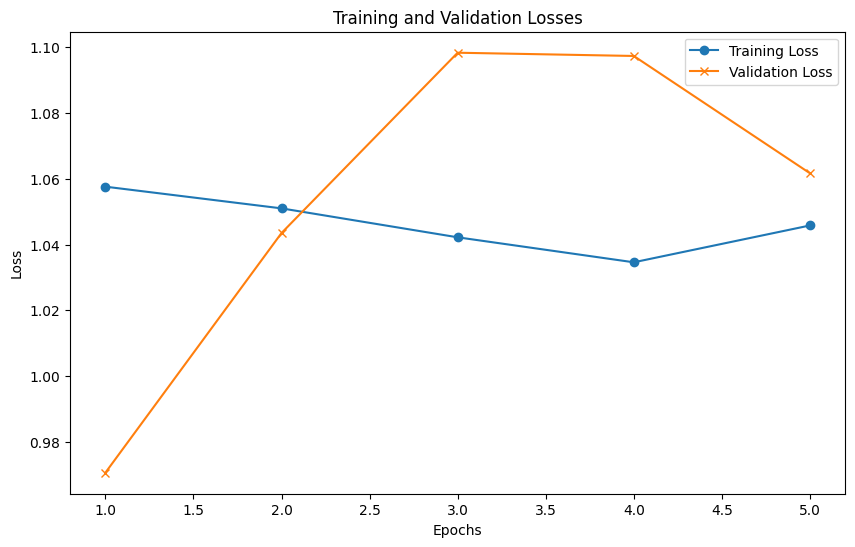

In [29]:
# Plot
# Assuming you have training and validation losses recorded
training_losses = [1.057600, 1.051000, 1.042200, 1.034600, 1.045800]
validation_losses = [0.970605, 1.043503, 1.098336, 1.097350, 1.061681]
epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', label='Training Loss')
plt.plot(epochs, validation_losses, marker='x', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()